In [36]:
#Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

In [23]:
#Loading the dataset

df = pd.read_csv('D:\\DataScience\\1.Personal Projects\\Datasets\\Twitter Sentiment Analysis\\training.1600000.processed.noemoticon.csv',encoding='iso-8859-1',names = ['id','date','no_query','user','tweet'])
df.head()

,id,date,no_query,user,tweet
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [24]:
#Dropping the unwanted columns

df.drop(['id','date','no_query','user'],axis=1,inplace=True)

In [25]:
df.reset_index(inplace=True)
df.head()

,index,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [26]:
#Chanign the col_names

df.columns = ['sentiment','tweet']
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [27]:
#Function to clearn the text

def clean_text(text):
    #Converting all the text to a lowercase for dimensionality reduction
    text = str(text).lower() 

    #Removing the handle names from the tweet
    text = re.sub('@\w+','',text)

    #Removing the urls from the tweet
    text = re.sub('https?://\S+|www\.\S+','',text)

    #Removing the punctuation marks from the tweet
    text = re.sub('[\./?,\[\]:;\,.-]','',text)

    #Removing the new line characters
    text = re.sub('\n','',text)
    return text

In [29]:
df['tweet_clean'] = df['tweet'].apply(clean_text)
df.head()

,sentiment,tweet,tweet_clean
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...


In [31]:
#Function to remove stopwords
stop_words = stopwords.words('English')
def remove_stopwords(text):
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [32]:
df['tweet_clean_stopwords_removed'] = df['tweet_clean'].apply(remove_stopwords)

In [33]:
df.drop(['tweet','tweet_clean'],axis=1,inplace=True)

In [34]:
df.head()

,sentiment,tweet_clean_stopwords_removed
0,0,awww that's bummer shoulda got david carr ...
1,0,upset can't update facebook texting might cry ...
2,0,dived many times ball managed save 50% rest ...
3,0,whole body feels itchy like fire
4,0,behaving i'm mad can't see


In [37]:
def lemmatization(text):
    lemma = WordNetLemmatizer()
    text = ' '.join([lemma.lemmatize(word) for word in text.split(' ')])
    return text
df['tweet_clean_lemmatized'] = df['tweet_clean_stopwords_removed'].apply(lemmatization)

In [38]:
df.head()

,sentiment,tweet_clean_stopwords_removed,tweet_clean_lemmatized
0,0,awww that's bummer shoulda got david carr ...,awww that's bummer shoulda got david carr ...
1,0,upset can't update facebook texting might cry ...,upset can't update facebook texting might cry ...
2,0,dived many times ball managed save 50% rest ...,dived many time ball managed save 50% rest g...
3,0,whole body feels itchy like fire,whole body feel itchy like fire
4,0,behaving i'm mad can't see,behaving i'm mad can't see


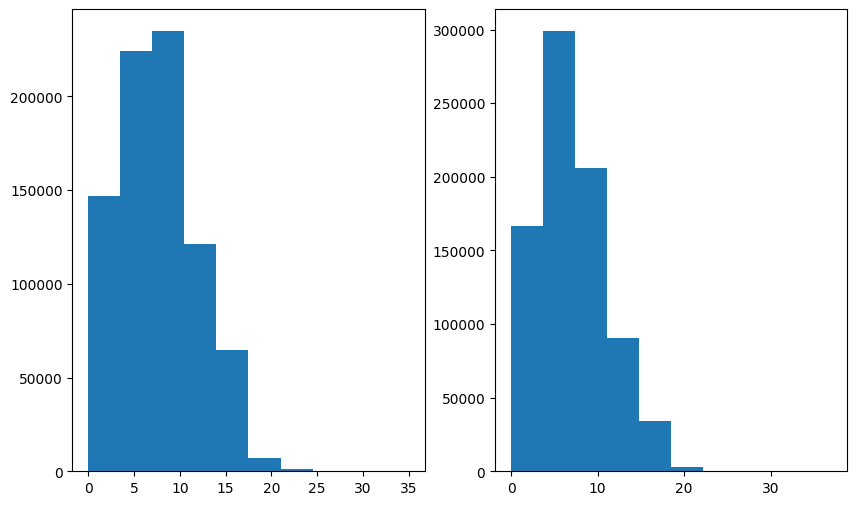

In [55]:
#Length of tweets in each category
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
tweet_len = df[df['sentiment']==0]['tweet_clean_lemmatized'].str.split().apply(lambda x:len(x))
sns.histplot(tweet_len,ax=ax1,color ='red')

tweet_len = df[df['sentiment']==4]['tweet_clean_lemmatized'].str.split().apply(lambda x:len(x))
sns.histplot(tweet_len,ax=ax2,color='green')
plt.show()